# Aprendizaje Automático 2
Tecnicatura Universitaria en Inteligencia Artificial

Materia: IA5.1 Aprendizaje Automático 2

**Trabajo Práctico 2: Redes Recurrentes**

**Problema 1 - Audio MNIST**


**Docentes:**
- Matias Moreyra
- Bruno Cocitto
- Facundo Moreyra


**Integrantes:**

| Apellido y Nombre | Legajo   |
| ----------------- | -------- |
| Aguirre, Fabián   | A-4516/1 |
| Fontela, Facundo  | F-3724/9 |
| Wagner, Juan      | W-0557/6 |

Año: 2024


# 1) Problema 1 - Audio MNIST

## Enunciado

### <u>Descripción</u>
En este problema, se presenta un conjunto de datos que contiene clips de audio correspondientes a dígitos hablados del 0 al 9.

### <u>Dataset</u>
https://www.tensorflow.org/datasets/catalog/spoken_digit

El dataset proporcionado incluye un total de 2500 clips de audio correspondientes a 5 locutores distintos, 50 clips por dígito por locutor.

### <u>Objetivo</u>
Utilizando el dataset proporcionado, el objetivo es construir un modelo de clasificación utilizando redes neuronales que pueda inferir con precisión el dígito correspondiente dado un clip de audio. Se deben entrenar y evaluar modelos utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.


Se solicita entrenar dos modelos de distintas arquitecturas y comparar los resultados:
- Modelo convolucional sobre los espectrogramas de los clips.
- Modelo recurrente sobre los espectrogramas de los clips.

Ver https://colab.research.google.com/github/FCEIA-AAII/lab11/blob/master/lab11-a.ipynb como ejemplo de obtención de espectrogramas a partir de clips de audio.

### <u>Entrega</u>
La entrega debe incluir:
- Código fuente de la solución implementada en Google Colab, que incluya:
  - Análisis previo y preprocesamiento del set de datos.
  - Definición y entrenamiento del modelo.
  - Resultados de la evaluación de los modelos, incluyendo métricas de desempeño y visualizaciones relevantes.

Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.

## Resolucion

In [ ]:
7%pip install --quiet pydub

In [ ]:
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, LSTM, Reshape
from keras import models
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import time
from sklearn.metrics import classification_report

In [ ]:
import os
import pathlib
import shutil

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

In [ ]:
# Reproductibilidad de resultados
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Dataset

Descargamos todos los audios (.wav) del dataset 'spoken-digit' (https://www.tensorflow.org/datasets/catalog/spoken_digit) desde su repositorio.

Un dataset compuesto por 3000 archivos de audio sobre pronunciaciones de digitos (0-9) en ingles.

El mismo esta compuesto por 6 personas pronunciado 50 digitos.

El audio fue capturado con una frecuencia de muestreo de 8 kHz.

In [ ]:
DATASET_PATH = 'data/Jakobovski'
tf.keras.utils.get_file(
      'Jakobovski.zip',
      origin="https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip",
      extract=True,
      cache_dir='.',
      cache_subdir=pathlib.Path(DATASET_PATH))

'./data/Jakobovski/Jakobovski.zip'

In [ ]:
recordings_path = '/content/data/Jakobovski/free-spoken-digit-dataset-master/recordings'
!echo $recordings_path
!echo "$(ls -1 $recordings_path | wc -l) audios guardados en $recordings_path"

/content/data/Jakobovski/free-spoken-digit-dataset-master/recordings
3000 audios guardados en /content/data/Jakobovski/free-spoken-digit-dataset-master/recordings


Como todos los audios han sido guardados en un mismo directorio necesitamos agruparlos por clases para luego importarlo con `tf.keras.utils.audio_dataset_from_directory`.

In [ ]:
# Creamos el directorio de destino y lo preparamos para colocarle las diferentes instancias de clases.
data_dir = '/content/data/Jakobovski/free-spoken-digit-dataset-master/organized_recordings'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Crear las carpetas de 0 a 9
for i in range(10):
    folder_path = os.path.join(data_dir, str(i))
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Mover los archivos a sus respectivas carpetas
for filename in os.listdir(recordings_path):
    if filename.endswith(".wav"):
        digit = filename.split('_')[0]
        src_path = os.path.join(recordings_path, filename)
        dest_path = os.path.join(data_dir, digit, filename)
        shutil.move(src_path, dest_path)

In [ ]:
!for class_dir in /content/data/Jakobovski/free-spoken-digit-dataset-master/organized_recordings/*; \
do echo "La clase '$(basename $class_dir)' tiene $(ls -1 $class_dir | wc -l) muestras."; done

La clase '0' tiene 300 muestras.
La clase '1' tiene 300 muestras.
La clase '2' tiene 300 muestras.
La clase '3' tiene 300 muestras.
La clase '4' tiene 300 muestras.
La clase '5' tiene 300 muestras.
La clase '6' tiene 300 muestras.
La clase '7' tiene 300 muestras.
La clase '8' tiene 300 muestras.
La clase '9' tiene 300 muestras.


Se puede observar que cada clase tiene la misma cantidad de muestras, estando así el dataset balanceado.

Importamos los audios para crear el crear el dataset de entrenamiento y validacion.

In [ ]:
# Audios truncados a 1 segundo (ya que el audio es de 8000hz)
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    # 64 audios por lote
    batch_size=64,
    # 20% para realizar el seguimiento de la validacion
    validation_split=0.2,
    seed=0,
    # Tomamos 1 segundo como longitud de audio (audio sampleados a 8 kHz)
    output_sequence_length=8000,
    subset='both'
  )

label_names = np.array(train_ds.class_names)
print()
print("Nombre de las clases:", label_names)

Found 3000 files belonging to 10 classes.
Using 2400 files for training.
Using 600 files for validation.

Nombre de las clases: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Muestra del digito 2


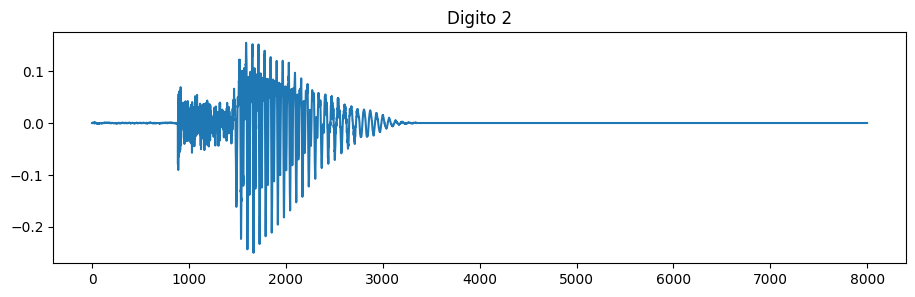

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  i=-1
  print("Muestra del digito",example_labels[i].numpy())
  display.display(display.Audio(example_audio[i], rate=8000))
  plt.figure(figsize=(11,3))
  plt.plot(example_audio[i])
  plt.title(f"Digito {example_labels[i]}")
  plt.show()

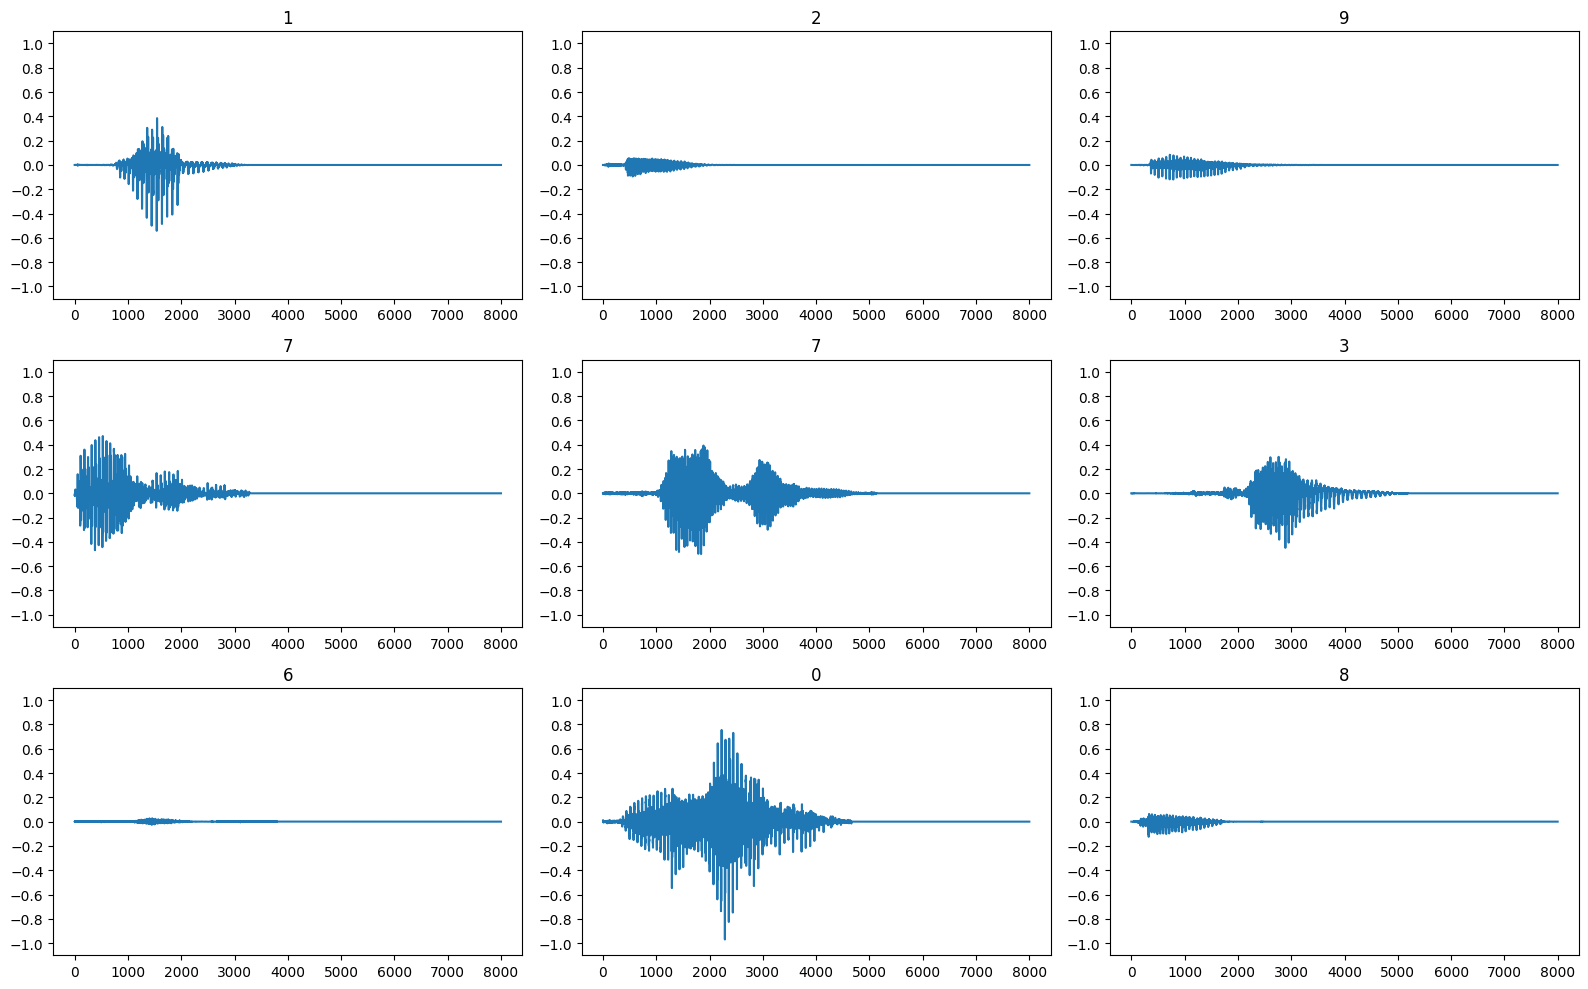

In [ ]:
# Mostramos algunos ondas de audio mas para ver a grandes rasgos el dataset
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols

for example_audio, example_labels in train_ds.take(1):
  for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()

Observando el lote, podemos ver como esta compuesto.

In [ ]:
"Audio: {0} elementos por lote, {1} longitud del muestreo por audio, {2} canales de audio".format(*iter(train_ds.take(1)).next()[0].shape)

'Audio: 64 elementos por lote, 8000 longitud del muestreo por audio, 1 canales de audio'

Dado que usar un solo canal es redundante a nivel de dataset, podemos achicarlo removiendo la dimensión innecesaria.

In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000, 1)
(64,)


In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 8000)
(64,)


Dado que las dos arquitecturas de redes neuronales que entrenaremos serán sobre el espectrograma, tenemos que construirlo.

In [ ]:
# Convertir la onda de audio a su espectrograma
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)

  # Magnitud de la STFT
  spectrogram = tf.abs(spectrogram)
  # Agregamos una columna mas representando al unico canal de audio
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

# Graficar espectrogramas sobre un eje
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Label: 7
Waveform shape: (8000,)
Spectrogram shape: (61, 129, 1)
Audio playback


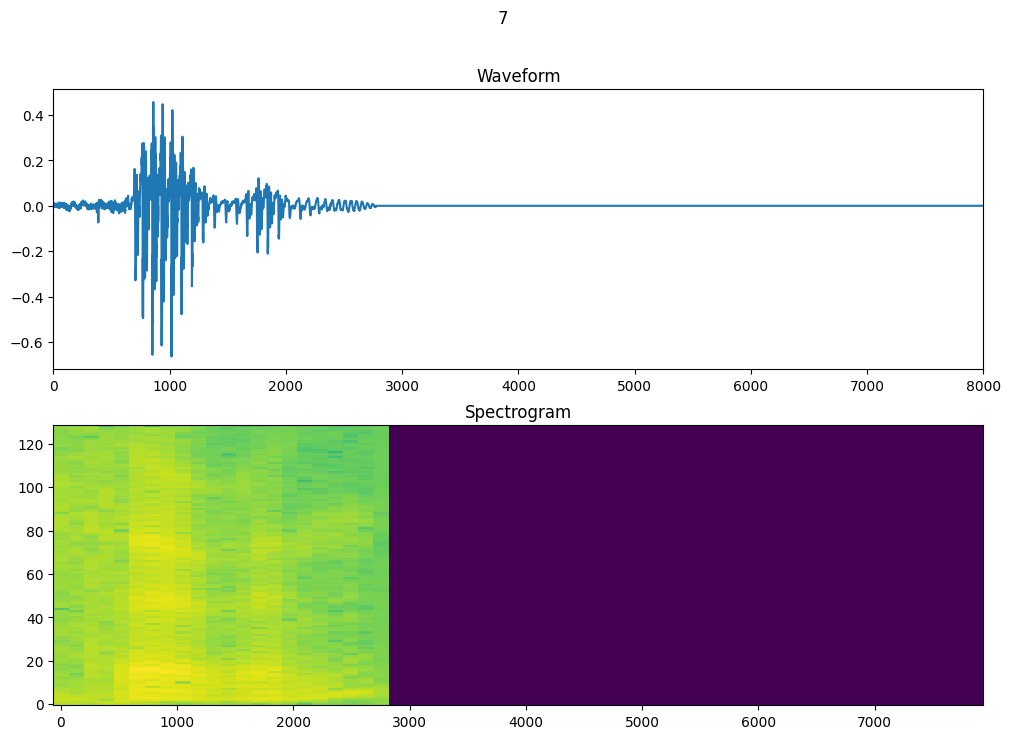

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))

for example_audio, example_labels in train_ds.take(1):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

  timescale = np.arange(waveform.shape[0])
  axes[0].plot(timescale, waveform.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 8000])

  plot_spectrogram(spectrogram.numpy(), axes[1])
  axes[1].set_title('Spectrogram')
  plt.suptitle(label.title())
  plt.show()

In [ ]:
# Funcion para la transformacion de audios del dataset a espectrograma, conservando su label
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE
    )

# dataset convertidos a espectrogramas
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

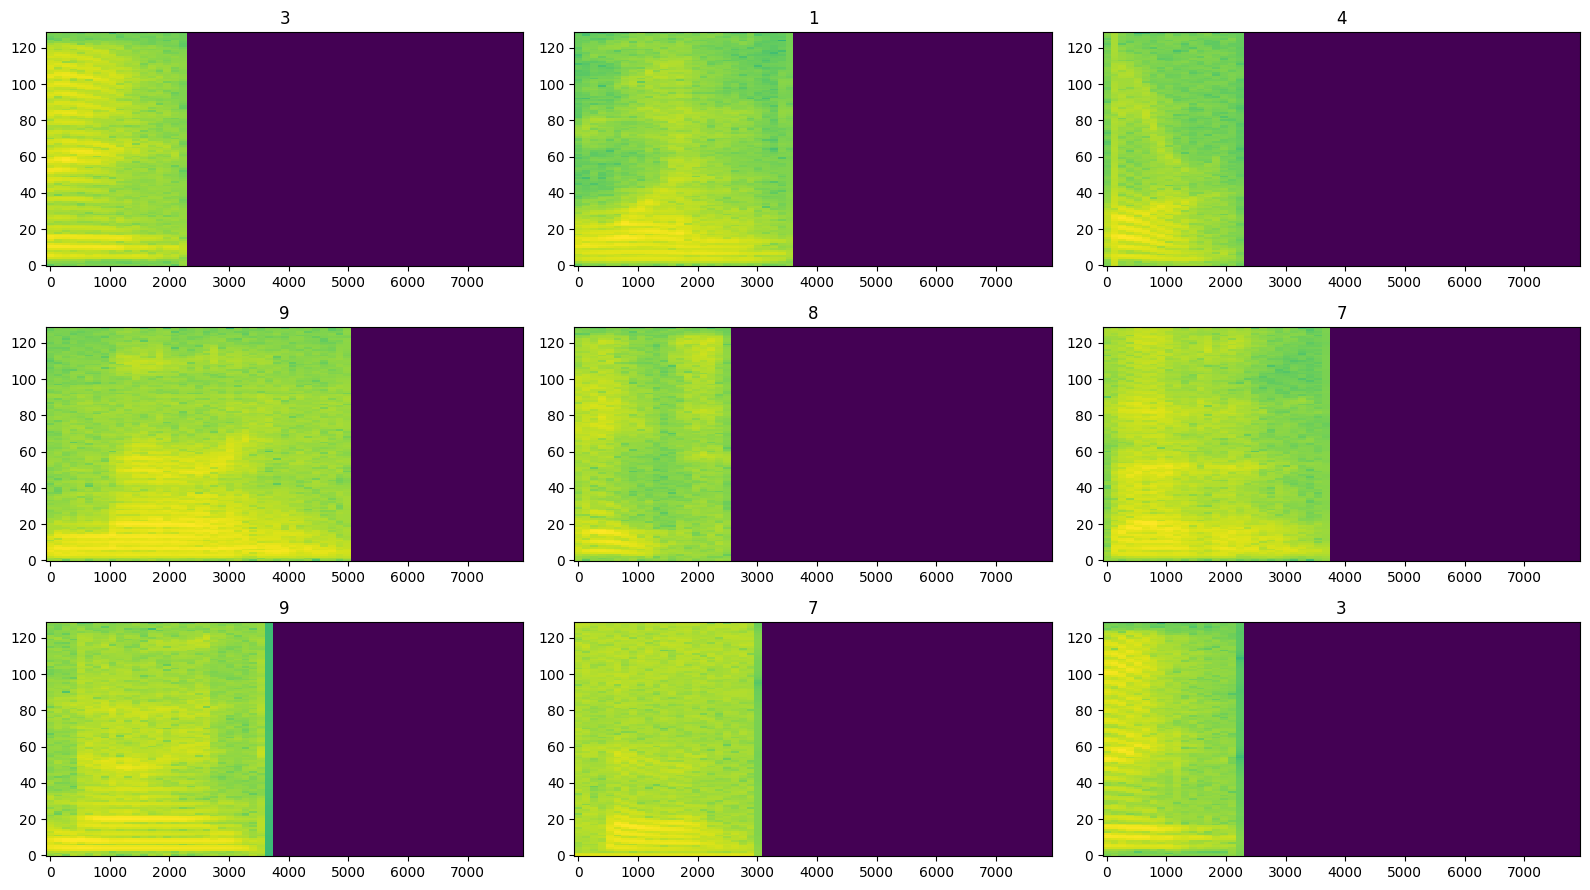

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
rows = 3
cols = 3
n = rows*cols
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  for i in range(n):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      plot_spectrogram(example_spectrograms[i].numpy(), ax)
      ax.set_title(label_names[example_spect_labels[i].numpy()])
plt.tight_layout()
plt.show()

### Modelo convolucional sobre espectrogramas

In [ ]:
# Optimizamos el dataset para el entrenamiento
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
example_spectrograms, example_spect_labels = iter(train_spectrogram_ds.take(1)).next()
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)
print('Labels:',num_labels)

# Definimos capa de normalizacion utilizando los datos de entrenamiento
norm_layer_cnn = layers.Normalization()
norm_layer_cnn.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    # Reducimos el tamaño de las imagens para aumentar la velocidad
    layers.Resizing(32, 32),
    norm_layer_cnn,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # salida lineal -> usamos los logits en la funcion perdida
    layers.Dense(num_labels),
], name="CNN")

model_cnn.summary()

Input shape: (61, 129, 1)
Labels: 10
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_12 (Resizing)      (None, 32, 32, 1)         0         
                                                                 
 normalization_17 (Normaliz  (None, 32, 32, 1)         3         
 ation)                                                          
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_29 (Dropout)     

In [ ]:
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    # Funcion perdida multiclase, usa los logits de la ultima capa
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # seguimos la metrica globla de exactitud dado el dataset esta balanceado
    metrics=['accuracy'],
)

In [ ]:
# Se entrena durante 50 epocas con early stopping y checkpoints
EPOCHS = 50
history_cnn = model_cnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='cnn.h5',
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
      ],
)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: 1.8058 - accuracy: 0.3908
Epoch 1: val_loss improved from inf to 1.15594, saving model to cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 7s 54ms/step - loss: 1.8058 - accuracy: 0.3908 - val_loss: 1.1559 - val_accuracy: 0.6733
Epoch 2/50
34/38 [=========================>....] - ETA: 0s - loss: 1.1271 - accuracy: 0.6306
Epoch 2: val_loss improved from 1.15594 to 0.82227, saving model to cnn.h5
38/38 [==============================] - 1s 19ms/step - loss: 1.1316 - accuracy: 0.6313 - val_loss: 0.8223 - val_accuracy: 0.7583
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.8243 - accuracy: 0.7437
Epoch 3: val_loss improved from 0.82227 to 0.57965, saving model to cnn.h5
38/38 [==============================] - 1s 16ms/step - loss: 0.8243 - accuracy: 0.7437 - val_loss: 0.5797 - val_accuracy: 0.8633
Epoch 4/50
38/38 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7854
Epoch 4: val_loss improved from 0.57965 to 0.46246, saving model to cnn.h5
38/38 [==============================] - 1s 17ms/step - loss: 0.6622 - accuracy: 0.7854 - val_loss: 0.4

Text(0, 0.5, 'Accuracy [%]')

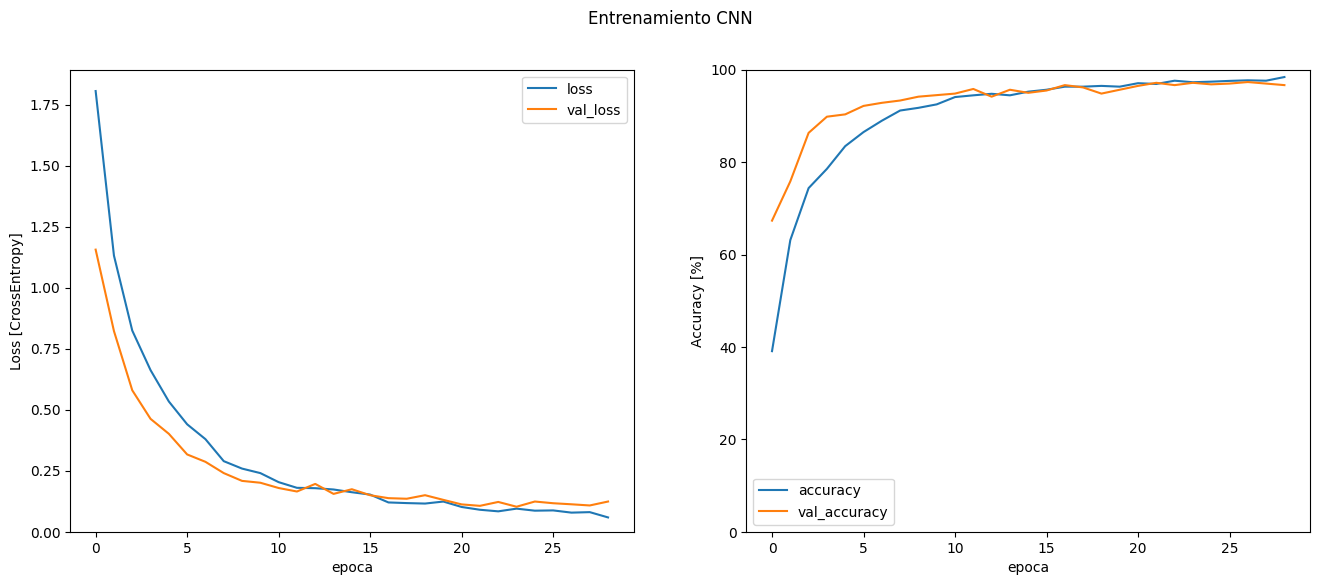

In [ ]:
# El modelo llego a un accuracy de 0.98, al ser un dataset balanceado es un buen paramatero, representativo.
# Podemos decir que las ultimas epocas se observa un overfitting

metrics_cnn = history_cnn.history
plt.figure(figsize=(16,6))
plt.suptitle("Entrenamiento CNN")
plt.subplot(1,2,1)
plt.plot(history_cnn.epoch, metrics_cnn['loss'], metrics_cnn['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('epoca')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_cnn.epoch, 100*np.array(metrics_cnn['accuracy']), 100*np.array(metrics_cnn['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('epoca')
plt.ylabel('Accuracy [%]')

El modelo tiende a overfittear los datos. Ha aprendio en forma constante y convergente hacia una estacionalidad.

Evaluamos el performance del mejor modelo entrenado.

10/10 [==============================] - 0s 4ms/step - loss: 0.1024 - accuracy: 0.9717
Best Acc: 0.971666693687439  Loss:0.1024114266037941
10/10 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           1       0.95      1.00      0.97        52
           2       0.99      0.99      0.99        69
           3       0.95      0.93      0.94        60
           4       1.00      0.99      0.99        69
           5       1.00      0.98      0.99        55
           6       0.98      0.93      0.95        68
           7       0.97      0.98      0.97        59
           8       0.90      1.00      0.95        54
           9       1.00      0.97      0.98        62

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



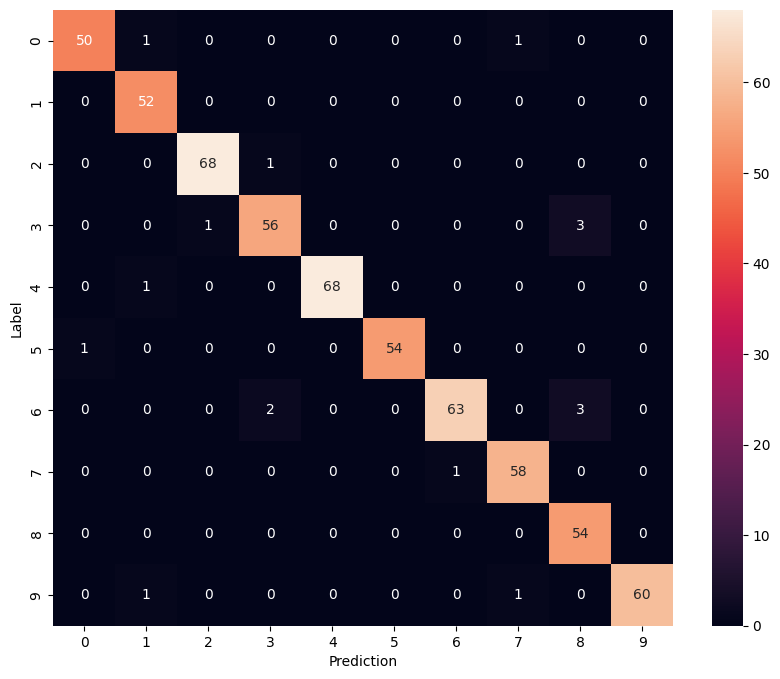

In [ ]:
best_cnn_model = tf.keras.models.load_model('cnn.h5')
print("Best Acc: {1}  Loss:{0}".format(*best_cnn_model.evaluate(val_spectrogram_ds)))
y_cnn_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
y_cnn_pred_best = tf.argmax(best_cnn_model.predict(val_spectrogram_ds), axis=1)

confusion_mtx = tf.math.confusion_matrix(
    y_cnn_true,
    y_cnn_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
print(classification_report(y_cnn_true, y_cnn_pred_best, target_names=label_names))
plt.show()

Todas métricas 0.97, indicando que es muy bueno clasificando digitos.

### Modelo recurrente sobre espectrogramas

In [ ]:
norm_rnn_layer = layers.Normalization()
norm_rnn_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# Define the RNN model
model_rnn = models.Sequential([
    layers.Input(shape=input_shape),
    norm_rnn_layer,
    layers.Reshape(target_shape=(input_shape[0], input_shape[1] * input_shape[2])),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
], name="RNN")

model_rnn.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_18 (Normaliz  (None, 61, 129, 1)        3         
 ation)                                                          
                                                                 
 reshape_5 (Reshape)         (None, 61, 129)           0         
                                                                 
 bidirectional_10 (Bidirect  (None, 61, 256)           264192    
 ional)                                                          
                                                                 
 bidirectional_11 (Bidirect  (None, 128)               164352    
 ional)                                                          
                                                                 
 dense_36 (Dense)            (None, 128)               16512     
                                                               

In [ ]:
model_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 50
history_rnn = model_rnn.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
        tf.keras.callbacks.ModelCheckpoint(
            filepath='rnn.h5',
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        )
      ],
)

Epoch 1/50
35/38 [==========================>...] - ETA: 0s - loss: 1.7287 - accuracy: 0.3963
Epoch 1: val_loss improved from inf to 0.86949, saving model to rnn.h5
38/38 [==============================] - 9s 55ms/step - loss: 1.6838 - accuracy: 0.4100 - val_loss: 0.8695 - val_accuracy: 0.7883


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
36/38 [===========================>..] - ETA: 0s - loss: 0.6743 - accuracy: 0.7764
Epoch 2: val_loss improved from 0.86949 to 0.34629, saving model to rnn.h5
38/38 [==============================] - 1s 22ms/step - loss: 0.6628 - accuracy: 0.7796 - val_loss: 0.3463 - val_accuracy: 0.8817
Epoch 3/50
36/38 [===========================>..] - ETA: 0s - loss: 0.3459 - accuracy: 0.8882
Epoch 3: val_loss improved from 0.34629 to 0.25722, saving model to rnn.h5
38/38 [==============================] - 1s 18ms/step - loss: 0.3383 - accuracy: 0.8908 - val_loss: 0.2572 - val_accuracy: 0.9233
Epoch 4/50
36/38 [===========================>..] - ETA: 0s - loss: 0.1935 - accuracy: 0.9427
Epoch 4: val_loss improved from 0.25722 to 0.17250, saving model to rnn.h5
38/38 [==============================] - 1s 24ms/step - loss: 0.1946 - accuracy: 0.9429 - val_loss: 0.1725 - val_accuracy: 0.9467
Epoch 5/50
36/38 [===========================>..] - ETA: 0s - loss: 0.1504 - accuracy: 0.9564
Epoch 5: 

Text(0, 0.5, 'Accuracy [%]')

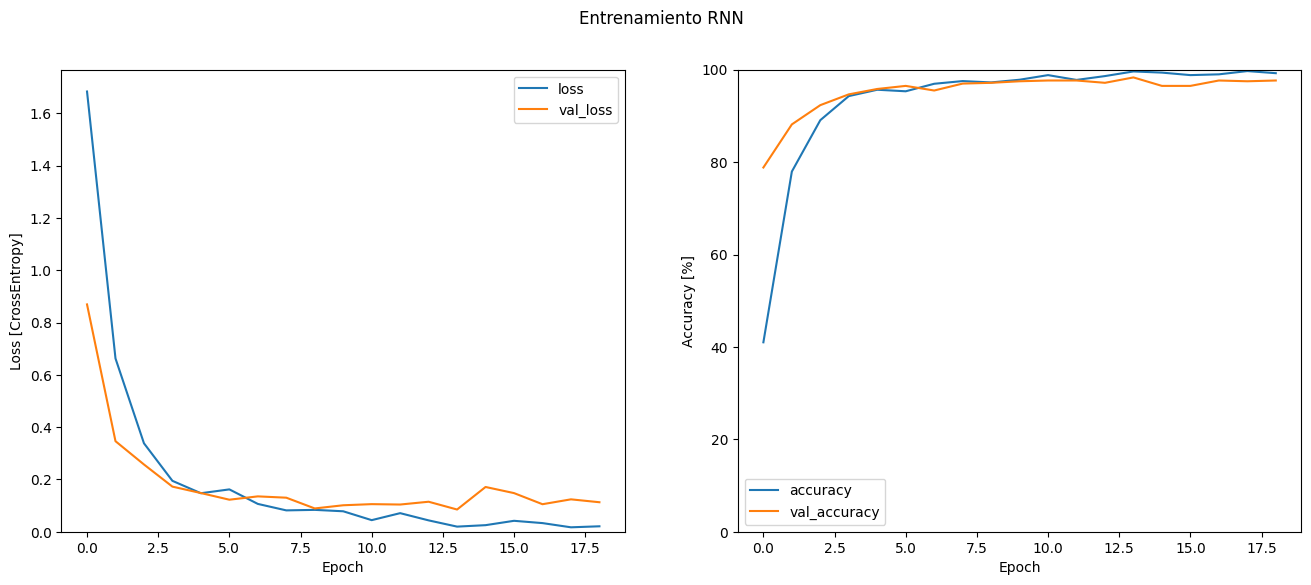

In [ ]:
# El entrenamiento corta con un early stopiing en la epoca 16
# Con respecto a metricas, se oberva un rendimiento muy similar

metrics_rnn = history_rnn.history
plt.figure(figsize=(16,6))
plt.suptitle("Entrenamiento RNN")
plt.subplot(1,2,1)
plt.plot(history_rnn.epoch, metrics_rnn['loss'], metrics_rnn['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_rnn.epoch, 100*np.array(metrics_rnn['accuracy']), 100*np.array(metrics_rnn['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

10/10 [==============================] - 2s 12ms/step - loss: 0.0849 - accuracy: 0.9833
Best Acc: 0.9833333492279053  Loss:0.08492264151573181
10/10 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      0.96      0.97        52
           2       0.99      1.00      0.99        69
           3       1.00      0.95      0.97        60
           4       1.00      1.00      1.00        69
           5       0.96      0.96      0.96        55
           6       0.97      0.99      0.98        68
           7       0.97      1.00      0.98        59
           8       0.98      0.98      0.98        54
           9       0.98      1.00      0.99        62

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



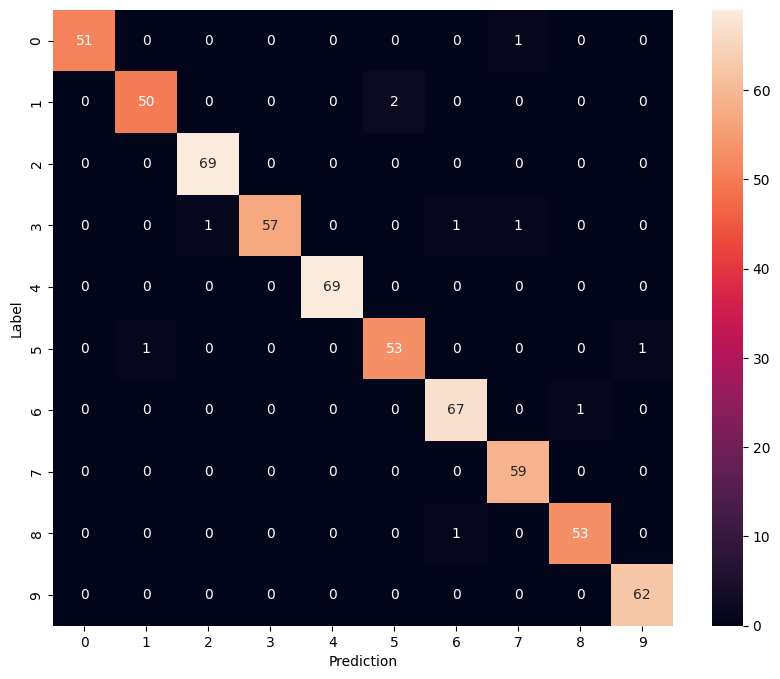

In [ ]:
best_rnn_model = tf.keras.models.load_model('rnn.h5')
print("Best Acc: {1}  Loss:{0}".format(*best_rnn_model.evaluate(val_spectrogram_ds)))
y_rnn_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
y_rnn_pred_best = tf.argmax(best_rnn_model.predict(val_spectrogram_ds), axis=1)

confusion_mtx = tf.math.confusion_matrix(y_rnn_true, y_rnn_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
print(classification_report(y_rnn_true, y_rnn_pred_best, target_names=label_names))
plt.show()

### Comparativa de los modelos

Compararemos diferentes metricas entre los modelos de clasificacion para los mejores modelos de ambas arquitecturas.

In [ ]:
print("CNN")
print(classification_report(y_cnn_true, y_cnn_pred_best, target_names=label_names))

print("RNN")
print(classification_report(y_rnn_true, y_rnn_pred_best, target_names=label_names))

CNN
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        52
           1       0.95      1.00      0.97        52
           2       0.99      0.99      0.99        69
           3       0.95      0.93      0.94        60
           4       1.00      0.99      0.99        69
           5       1.00      0.98      0.99        55
           6       0.98      0.93      0.95        68
           7       0.97      0.98      0.97        59
           8       0.90      1.00      0.95        54
           9       1.00      0.97      0.98        62

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600

RNN
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        52
           1       0.98      0.96      0.97        52
           2       0.99      1.00      0.99        69
           3    

De aqui podemos ver que el modelo basado en Redes Recurrentes fue levemente supeior, pero en sí tiene metricas praticamente identicas.

Si bien ambos entrenamiento fueron veloces, hay que destacar una características observada durante el entrenamiento.

Para entrenar la CNN, se necesio ajustar un total de 1_625_866 parametros mientras que para entrenar la RNN se tuvo que ajustar 446_346 parametros. 4 veces menos.


Además, la RNN llego a un estado estacionario en menos epocas que la CNN.

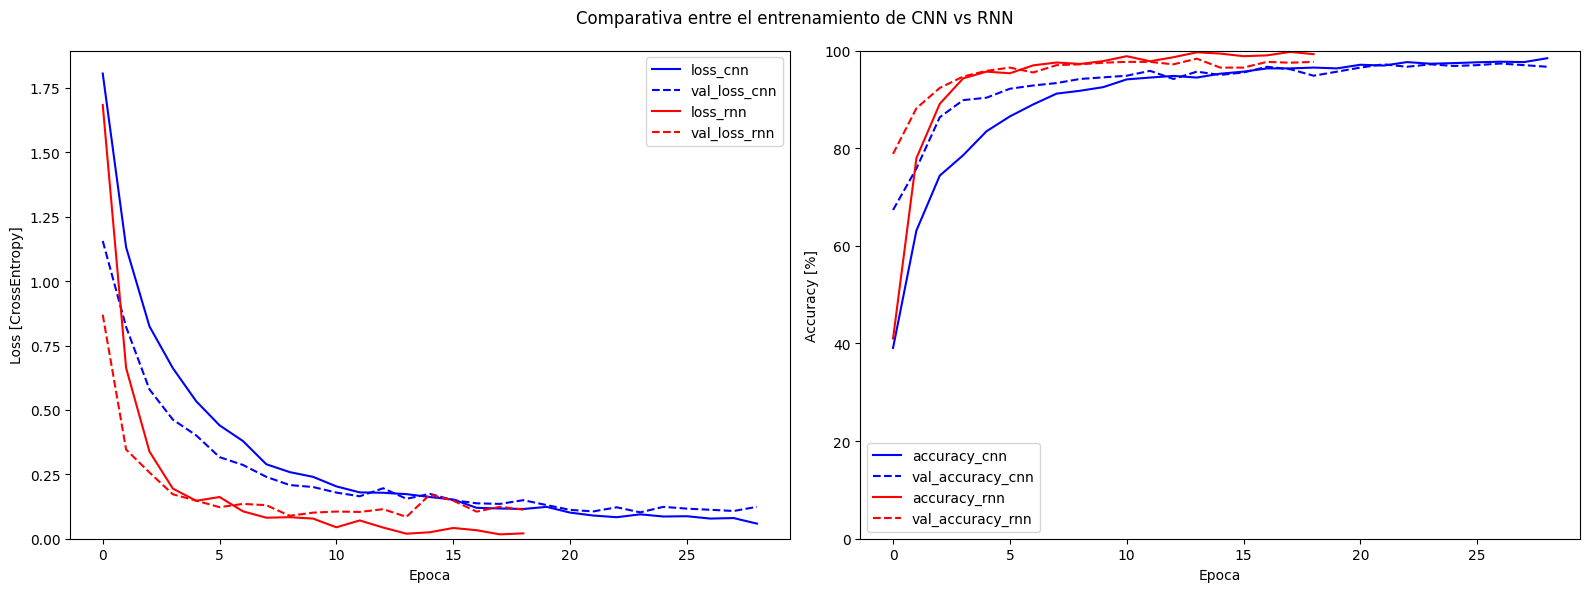

In [ ]:
plt.figure(figsize=(16,6))
plt.suptitle("Comparativa entre el entrenamiento de CNN vs RNN")

plt.subplot(1, 2, 1)
plt.plot(history_cnn.epoch, metrics_cnn['loss'], 'b-', label='loss_cnn')
plt.plot(history_cnn.epoch, metrics_cnn['val_loss'], 'b--', label='val_loss_cnn')
plt.plot(history_rnn.epoch, metrics_rnn['loss'], 'r-', label='loss_rnn')
plt.plot(history_rnn.epoch, metrics_rnn['val_loss'], 'r--', label='val_loss_rnn')
plt.legend()
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoca')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.epoch, 100 * np.array(metrics_cnn['accuracy']), 'b-', label='accuracy_cnn')
plt.plot(history_cnn.epoch, 100 * np.array(metrics_cnn['val_accuracy']), 'b--', label='val_accuracy_cnn')
plt.plot(history_rnn.epoch, 100 * np.array(metrics_rnn['accuracy']), 'r-', label='accuracy_rnn')
plt.plot(history_rnn.epoch, 100 * np.array(metrics_rnn['val_accuracy']), 'r--', label='val_accuracy_rnn')
plt.legend()
plt.ylim([0, 100])
plt.xlabel('Epoca')
plt.ylabel('Accuracy [%]')

plt.tight_layout()
plt.show()

Conclusión, haber utilizado tanto CNN como RNN para clasificar digitos observando su espectrograma ha demostrado ser bastante exitoso, capturando el 97,98% de los datos de prueba.